# 寄り付き後のトレンドの扱いと損切ロジックの評価

In [80]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

In [81]:
import datetime
import re

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import dates as mdates

from funcs.tse import get_ticker_name_list
from modules.psar import RealtimePSAR
from modules.simulator import LosscutSimulator

In [82]:
pattern = re.compile(r".+([0-9]{4})([0-9]{2})([0-9]{2})\.xlsx")

In [83]:
name_excel = "../excel/tick_20250703.xlsx"
#ticker = "7011"
#ticker = "7203"
ticker = "8306"

m = pattern.match(name_excel)
if m:
    year = m.group(1)
    month = m.group(2)
    day = m.group(3)
else:
    year = "1970"
    month = "01"
    day = "01"
date_str = f"{year}-{month}-{day}"
df = pd.read_excel(name_excel, sheet_name=ticker)
df.index = pd.to_datetime([datetime.datetime.fromtimestamp(t) for t in df["Time"]])
df

,Time,Price
2025-07-03 09:00:03.323193,1.751501e+09,1980.0
2025-07-03 09:00:04.336076,1.751501e+09,1980.0
2025-07-03 09:00:05.340197,1.751501e+09,1981.0
2025-07-03 09:00:06.338437,1.751501e+09,1981.0
2025-07-03 09:00:07.334416,1.751501e+09,1982.0
...,...,...
2025-07-03 15:24:45.255521,1.751524e+09,1985.0
2025-07-03 15:24:46.251195,1.751524e+09,1985.0
2025-07-03 15:24:47.248531,1.751524e+09,1985.0
2025-07-03 15:24:48.241816,1.751524e+09,1985.0


In [84]:
simulator = LosscutSimulator(ticker, df)
profit = simulator.run()
print(f"総収益 {profit} 円")
df

総収益 -1900 円


,Time,Price,MMPrice,Trend,EPupd,Duration,PSAR,Profit,Distance
2025-07-03 09:00:03.323193,1.751501e+09,1980.0,1980.0,0.0,0.0,0.0,0.000000,0.0,NaN
2025-07-03 09:00:04.336076,1.751501e+09,1980.0,1980.0,0.0,0.0,0.0,0.000000,0.0,NaN
2025-07-03 09:00:05.340197,1.751501e+09,1981.0,1980.0,0.0,0.0,0.0,0.000000,0.0,NaN
2025-07-03 09:00:06.338437,1.751501e+09,1981.0,1981.0,0.0,0.0,0.0,0.000000,0.0,NaN
2025-07-03 09:00:07.334416,1.751501e+09,1982.0,1981.0,0.0,0.0,0.0,0.000000,0.0,NaN
...,...,...,...,...,...,...,...,...,...
2025-07-03 15:24:45.255521,1.751524e+09,1985.0,1985.0,1.0,8.0,1838.0,1978.462145,400.0,6.537855
2025-07-03 15:24:46.251195,1.751524e+09,1985.0,1985.0,1.0,8.0,1839.0,1978.463322,400.0,6.536678
2025-07-03 15:24:47.248531,1.751524e+09,1985.0,1985.0,1.0,8.0,1840.0,1978.464499,400.0,6.535501
2025-07-03 15:24:48.241816,1.751524e+09,1985.0,1985.0,1.0,8.0,1841.0,1978.465675,400.0,6.534325


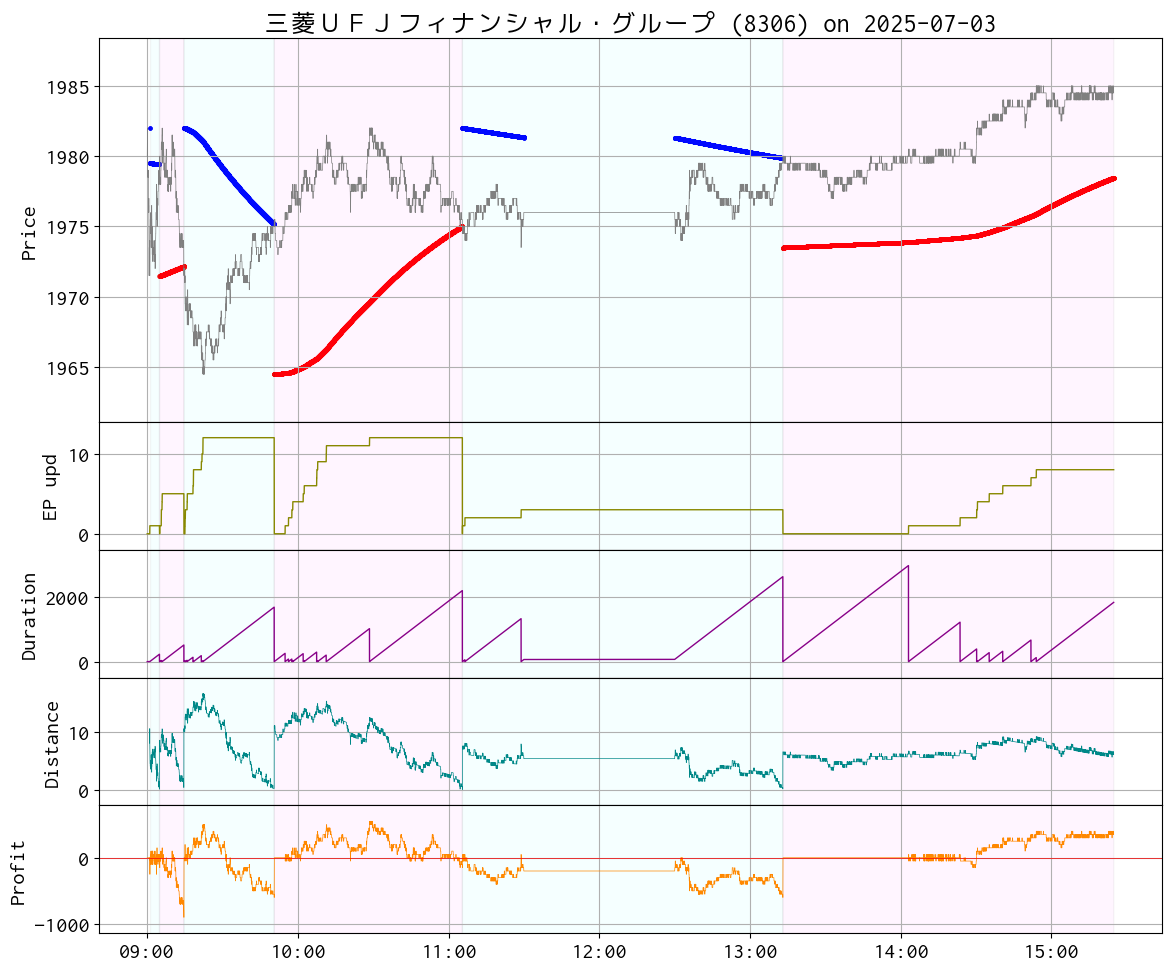

In [85]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 16
fig = plt.figure(figsize=(12, 10))
ax = dict()
n = 5
gs = fig.add_gridspec(
    n, 1, wspace=0.0, hspace=0.0, height_ratios=[3 if i == 0 else 1 for i in range(n)]
)
for i, axis in enumerate(gs.subplots(sharex="col")):
    ax[i] = axis
    ax[i].grid()

ax[0].plot(df["Price"], color="gray", linewidth=0.5)
ser_bull = df[0 < df["Trend"]]["PSAR"]
ser_bear = df[df["Trend"] < 0]["PSAR"]

ax[0].scatter(x=ser_bull.index, y=ser_bull, s=5, c="red")
ax[0].scatter(x=ser_bear.index, y=ser_bear, s=5, c="blue")
ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

ax[0].set_ylabel("Price")
dict_name = get_ticker_name_list([ticker])
ax[0].set_title(f"{dict_name[ticker]} ({ticker}) on {date_str}")

i = 1
ax[i].plot(df["EPupd"], color="#880", linewidth=1)
ax[i].set_ylabel("EP upd")

i = 2
ax[i].plot(df["Duration"], color="#808", linewidth=1)
ax[i].set_ylabel("Duration")

i = 3
ax[i].plot(df["Distance"], color="#088", linewidth=0.5)
ax[i].set_ylabel("Distance")

i = 4
ax[i].plot(df["Profit"], color="#f80", linewidth=0.5)
ax[i].axhline(0, color="red", linewidth=0.5)
ax[i].set_ylabel("Profit")

for i in range(n):
    x = df.index
    y = df["Trend"]
    ax[i].fill_between(
        x,
        0,
        1,
        where=y > 0,
        edgecolor="black",
        facecolor="magenta",
        alpha=0.04,
        transform=ax[i].get_xaxis_transform(),
    )
    ax[i].fill_between(
        x,
        0,
        1,
        where=y < 0,
        edgecolor="black",
        facecolor="cyan",
        alpha=0.04,
        transform=ax[i].get_xaxis_transform(),
    )

plt.tight_layout()
plt.savefig(f"screenshots/losscut_eval_{date_str}_{ticker}.png")
plt.show()